In [2]:
# Install part
!pip install torch torchvision matplotlib tqdm numpy

    100% |████████████████████████████████| 519.5MB 20kB/s 
tcmalloc: large alloc 1073750016 bytes == 0x59168000 @  0x7f6931cea1c4 0x46d6a4 0x5fcbcc 0x4c494d 0x54f3c4 0x553aaf 0x54e4c8 0x54f4f6 0x553aaf 0x54efc1 0x54f24d 0x553aaf 0x54efc1 0x54f24d 0x553aaf 0x54efc1 0x54f24d 0x551ee0 0x54e4c8 0x54f4f6 0x553aaf 0x54efc1 0x54f24d 0x551ee0 0x54efc1 0x54f24d 0x551ee0 0x54e4c8 0x54f4f6 0x553aaf 0x54e4c8
    100% |████████████████████████████████| 61kB 21.8MB/s 
    100% |████████████████████████████████| 2.0MB 5.2MB/s 
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0


In [0]:
### First part. BoilerPlate code

loss:0.1138: 100%|██████████| 500/500 [00:15<00:00, 32.38it/s]


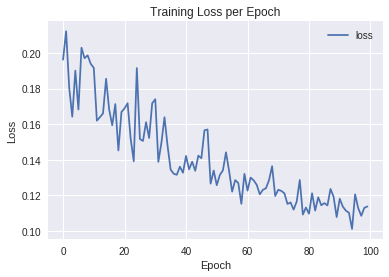

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, datasets
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

# Instruct matplotlib to draw inline
%matplotlib inline

# See if the cuda is avaliable and store it in device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


# Define the neural nets module which inherits the nn.Module
class Network(nn.Module):
    def __init__(self, dataset):
        super(Network, self).__init__()
        x, y = dataset[0]
        c, h, w = x.size()
        out = y.size(0)
        # One of the way to define the neural nets layers
        
        self.net = nn.Sequential(nn.Linear(c * h * w, out))
        
        # Defining multiple layer neural networks
        """
        self.net = nn.Sequential(
            nn.Linear(c * h * w, 1000),
            nn.Sigmoid(),
            nn.Linear(1000, out),
            )
        """
    # Forward pass. Backward pass is automatically implemented
    def forward(self, x):
        n, c, h, w = x.size()
        flattened = x.view(n , c * h * w)
        return self.net(flattened)


# Defining custom dataset processor
class FashionMNISTProcessedDataset(Dataset):
    def __init__(self, root, train=True):
        self.data = datasets.FashionMNIST(root=root, train=True,
                                            download=True, transform=transforms.ToTensor())
        # Identity matrix
        self.e = torch.eye(10)

    def __getitem__(self, i):
        x, y = self.data[i]
        # Only used if we want y as a scalar
        #return x, y.unsqueeze(0).float()
        # Y as an one hot encoding
        return x, self.e[y].float()

    def __len__(self):
        return 100 #len(self.data)

      
# Ploting the train loss   
def plot_train_loss(loss):
    #x = np.linspace(0, 2, 100)
    x = range(len(loss))

    plt.plot(x, loss, label='loss')

    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.title("Training Loss per Epoch")

    plt.legend()

    plt.show()


train_dataset = FashionMNISTProcessedDataset('/tmp/fashionmnist',train=True)
model = Network(train_dataset)
model = model.cuda()
loss_func = torch.nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.0001)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=20,
    shuffle=True, num_workers=2, pin_memory=True)

losses = []
loop = tqdm(total=len(train_loader)*100, position=0)
for epoch in range(100):

    for batch in train_loader:
        batch[0]=batch[0].cuda(async=True)
        batch[1]=batch[1].cuda(async=True)
        #print (batch[0], batch[1])
        optimizer.zero_grad()

        y_hat = model(batch[0])
        loss = loss_func(y_hat, batch[1])
        loss.backward()
        optimizer.step()
        loop.set_description('loss:{:.4f}'.format(loss.item()))
        loop.update(1)
    losses.append(loss)
    #print (loss)
loop.close()
plot_train_loss(losses)
#print (losses[-10:])

In [0]:
## Part 2: Training vs Validation set


loss:0.0866: 100%|██████████| 500/500 [00:32<00:00, 15.32it/s]


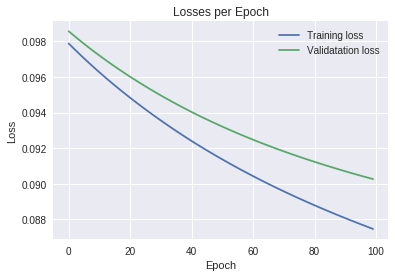

In [30]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, datasets
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

# Instruct matplotlib to draw inline
%matplotlib inline

# See if the cuda is avaliable and store it in device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


# Define the neural nets module which inherits the nn.Module
class Network(nn.Module):
    def __init__(self, dataset):
        super(Network, self).__init__()
        x, y = dataset[0]
        c, h, w = x.size()
        out = y.size(0)
        # One of the way to define the neural nets layers
        
        # self.net = nn.Sequential(nn.Linear(c * h * w, out))
        
        # Defining multiple layer neural networks
        self.net = nn.Sequential(
            nn.Linear(c * h * w, 1000),
            nn.ReLU(),
            nn.Linear(1000, 500),
            nn.ReLU(),
            nn.Linear(500, out),
            )
    # Forward pass. Backward pass is automatically implemented
    def forward(self, x):
        n, c, h, w = x.size()
        flattened = x.view(n , c * h * w)
        return self.net(flattened)


# Defining custom dataset processor
class FashionMNISTProcessedDataset(Dataset):
    def __init__(self, root, train=True):
        self.data = datasets.FashionMNIST(root=root, train=train,
            download=True, transform=transforms.ToTensor())
        # Identity matrix
        self.e = torch.eye(10)

    def __getitem__(self, i):
        x, y = self.data[i]
        # Only used if we want y as a scalar
        # return x, y.unsqueeze(0).float()
        # Y as an one hot encoding
        return x, self.e[y].float()

    def __len__(self):
        return 100 #len(self.data)

      
# Ploting the train loss   
def plot_train_loss(loss):
    #x = np.linspace(0, 2, 100)
    x = range(len(loss))

    plt.plot(x, loss, label='loss')

    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.title("Training Loss per Epoch")

    plt.legend()

    plt.show()


# Ploting the train loss   
def plot_both_loss(loss, vloss):
    #x = np.linspace(0, 2, 100)
    x = range(len(loss))

    plt.plot(x, loss, label='Training loss')
    plt.plot(x, vloss, label='Validatation loss')

    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.title("Losses per Epoch")

    plt.legend()

    plt.show()    
    

def validatation_loop():
  # Get the validation data and do a forward pass through the neural net
  loss_batch = []
  for x, y in valid_loader:
    # Send both data and lable to cuda
    x = x.cuda(async=True)
    y = y.cuda(async=True)
    # Do the forward pass 
    y_hat = model(x)
    # Compute the loss. Prediction vs Real value
    loss = loss_func(y_hat, y)
    
    # Add the loss to the list
    loss_batch.append(loss)
    
  loss = torch.mean(torch.tensor(loss_batch))
  return loss
    
# Load the training data in this case it Fashionmnist
train_dataset = FashionMNISTProcessedDataset('/tmp/fashionmnist',train=True)

# Load the validation data 
validatation_dataset = FashionMNISTProcessedDataset(
    '/tmp/fashionmnist',train=False)

# Build a neural net module passing this dataset
model = Network(train_dataset)

# Make sure that this model runs on cuda
model = model.cuda()

# Define the loss function. In this case MSELoss
loss_func = torch.nn.MSELoss()

# Define the optimizer to use. In this case SGD
optimizer = optim.SGD(model.parameters(), lr=0.001)

# Get the training data in a mini-batch
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=20,
    shuffle=False, num_workers=2, pin_memory=True)

# Get the validatation data in a mini-batch
valid_loader = torch.utils.data.DataLoader(validatation_dataset, batch_size=20,
    shuffle=True, num_workers=2, pin_memory=True)

# Define a list to store all the losses
losses = []
valid_losses = []
# Define a tqdm instance to see the progress bar
loop = tqdm(total=len(train_loader)*100, position=0)

for epoch in range(100):
    # Define a list for batch loss
    batch_losses = []
    # For each data batch from training data
    for batch in train_loader:
        # batch[0] is the data and 1 is the label
        batch[0]=batch[0].cuda(async=True)
        batch[1]=batch[1].cuda(async=True)
        
        # Reset the grad value to zero
        optimizer.zero_grad()
        
        # Predicted value 
        y_hat = model(batch[0])
        
        # Compute the loss
        loss = loss_func(y_hat, batch[1])
        
        # Propagate the loss backward. Backprop
        loss.backward()
        
        # Update the weights
        optimizer.step()
        
        # Set the tqdm params
        loop.set_description('loss:{:.4f}'.format(loss.item()))
        loop.update(1)
        
        # Append the loss to compute the average
        batch_losses.append(loss)
    
    # Call the validatation step
    valid_loss = validatation_loop()
  
    # Compute average loss for that batch
    loss = torch.mean(torch.tensor(batch_losses))
    
    # Append the average loss to draw graph
    losses.append(loss)
    valid_losses.append(valid_loss)

# Close the loop display
loop.close()

# Draw the plot
plot_both_loss(losses, valid_losses)